## 1. Creating Frame Tensor Data
### 1.1 Imports

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from time import *
import os 
import pickle
import pandas as pd

### 1.2 MediaPipe Landmarks

In [2]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False  # image is unwritable
    results = model.process(image)  # make prediction
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results


def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION)
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

### 1.3 Numpy File Creation/Storage
#### Note: This assumes that the photos are pre-separated into their own directories

In [6]:
# directory will be where the dictionary of image frames are pulled from
directory = "./Test_Words"
print(directory)
# run all directories in data
for subdirectory in os.listdir(directory):
    new_dir = os.path.join('./Numpy_Files', f'{subdirectory}')
    os.mkdir(new_dir)
    frames = []
    index = 1
# run for all files in each subdirectory in data
    for frame_set in os.listdir(os.path.join(directory,subdirectory)):
        for file in os.listdir(os.path.join(directory, subdirectory, frame_set)):
            # don't change this
            mp_holistic = mp.solutions.holistic #holistic model
            mp_drawing = mp.solutions.drawing_utils #drawing utility
            cap = cv2.VideoCapture(os.path.join(directory,subdirectory,frame_set, file))
            
            with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
                while cap.isOpened():
                    ref, frame = cap.read()
                    if ref is False:
                        break
                # Make Detections
                    image, results = mediapipe_detection(frame, holistic)
                    rh = np.array([[res.x, res.y, res.z] for res in
                                results.right_hand_landmarks.landmark]) if results.right_hand_landmarks else np.full([21, 3], 0)
                    lh = np.array([[res.x, res.y, res.z] for res in
                                results.left_hand_landmarks.landmark]) if results.left_hand_landmarks else np.full([21, 3], 0)
                    face = np.array([[res.x, res.y, res.z] for res in
                                    results.face_landmarks.landmark]) if results.face_landmarks else np.full([468,3], 0)
                    pose = np.array([[res.x, res.y, res.z] for res in
                                    results.pose_landmarks.landmark]) if results.pose_landmarks else np.full([33,4], 0)
                # Draw Landmarks
                    # Put all the landmarks into a 1d numpy array with the xyz coordinates for face, pose, rh and lh
                    landmarks_split = [rh, lh, face, pose]
                    frames.append(landmarks_split)
                
                    draw_landmarks(image, results)
                    
                    cv2.imshow("OpenCV Capture", image)
                    if cv2.waitKey(10) & 0xFF == ord('q'):
                        break
                        
            cap.release()
            cv2.destroyAllWindows()

        # saves files by name to the set subdirectory in Numpy_Files
        filename = f'{os.path.basename(frame_set)}'
        file_data = np.array(frames, dtype=object)
        np.save(os.path.join(f'./Numpy_Files/{subdirectory}', filename), file_data)
    

./Test_Words


## 2. Data Cleaning
#### Note: Previously, data was cleaned by hand, but this is to automate that
### 2.1. Image Color Detection

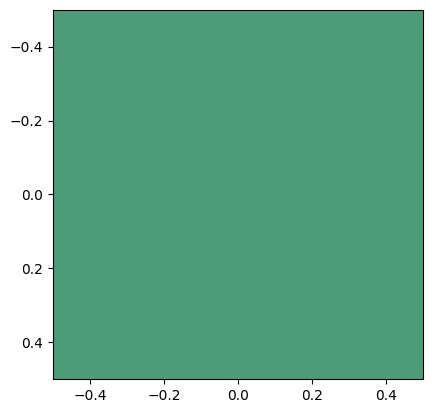

(76, 156, 122)


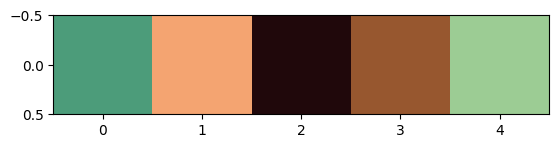

[(76, 156, 122), (244, 164, 113), (32, 8, 11), (151, 87, 47), (156, 204, 148)]


In [2]:
from colorthief import ColorThief
from matplotlib import pyplot as plt

ct = ColorThief("./Test_Words/favorite/favorite2/2130410.jpg")

dominant_color = ct.get_color(quality=1) # color is stored as a tuple (R, G, B)
plt.imshow([[dominant_color]])
plt.show()
print(dominant_color)

palette = ct.get_palette(color_count=5) # palette is stored as a list of 5 colors
plt.imshow([[palette[i] for i in range(5)]]) 
plt.show()
print(palette)

In [11]:
import colorsys

for color in palette:
    print(color) # in RGB
    print(f"#{color[0]:02x}{color[1]:02x}{color[2]:02x}")
    print(colorsys.rgb_to_hsv(*color))
    print(colorsys.rgb_to_hls(*color))

(76, 156, 122)
#4c9c7a
(0.4291666666666667, 0.5128205128205128, 156)
(0.4291666666666667, 116.0, -0.34782608695652173)
(244, 164, 113)
#f4a471
(0.0648854961832061, 0.5368852459016393, 244)
(0.0648854961832061, 178.5, -0.36901408450704226)
(32, 8, 11)
#20080b
(0.9791666666666666, 0.75, 32)
(0.9791666666666666, 20.0, -0.631578947368421)
(151, 89, 44)
#97592c
(0.07009345794392524, 0.7086092715231788, 151)
(0.07009345794392524, 97.5, -0.5544041450777202)
(160, 204, 152)
#a0cc98
(0.3076923076923077, 0.2549019607843137, 204)
(0.3076923076923077, 178.0, -0.14689265536723164)


### 2.2. Image Color Sorting
#### Method for sorting the RGB values first 

In [ ]:
import math

def color_code(directory): # 'test' directory
    color_list = [] # will store one of each dominant color
    for image_set in os.listdir(directory): # any of the individual word directories
        for image in os.listdir(os.path.join(directory,image_set)): # any of the images within the subdirectories
            temp_color = image.get_color(quality=1)
            for i in range(0,3):
                if math.isclose(image.get_color(quality=1)[i], temp_color[i], 10.0):
                    continue
                else:
                    if image.get_color(quality=1) not in color_list:
                        color_list.append(image.get_color(quality=1))
                    temp_color = image.get_color(quality=1)